In [1]:
#install kaggle
! pip install -q kaggle

In [1]:
#import files from google colab
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ashleshap001","key":"7e31cc5929fc52b431ced46a378ec4e5"}'}

In [2]:
#Create directory
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [3]:
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
! kaggle datasets download -d puneet6060/intel-image-classification

 98% 341M/346M [00:04<00:00, 37.5MB/s]
100% 346M/346M [00:04<00:00, 72.8MB/s]


In [5]:
#unzip the file
! unzip intel-image-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: seg_train/seg_train/mountain/7506.jpg  
  inflating: seg_train/seg_train/mountain/7537.jpg  
  inflating: seg_train/seg_train/mountain/7539.jpg  
  inflating: seg_train/seg_train/mountain/7551.jpg  
  inflating: seg_train/seg_train/mountain/7560.jpg  
  inflating: seg_train/seg_train/mountain/7565.jpg  
  inflating: seg_train/seg_train/mountain/7578.jpg  
  inflating: seg_train/seg_train/mountain/7581.jpg  
  inflating: seg_train/seg_train/mountain/7586.jpg  
  inflating: seg_train/seg_train/mountain/7647.jpg  
  inflating: seg_train/seg_train/mountain/7652.jpg  
  inflating: seg_train/seg_train/mountain/7654.jpg  
  inflating: seg_train/seg_train/mountain/7662.jpg  
  inflating: seg_train/seg_train/mountain/767.jpg  
  inflating: seg_train/seg_train/mountain/7672.jpg  
  inflating: seg_train/seg_train/mountain/7679.jpg  
  inflating: seg_train/seg_train/mountain/7681.jpg  
  inflating: seg_train/seg_train/mountain/7693.jp

In [6]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import tensorflow.keras.layers as Layers
import tensorflow.keras.models as Models
import tensorflow.keras.optimizers as Optimizer
import tensorflow.keras.metrics as Metrics
import tensorflow.keras.utils as Utils #visualization
from tensorflow.keras.utils import model_to_dot
from tensorflow.keras.callbacks import EarlyStopping
import os
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics import confusion_matrix as CM
from random import randint
from IPython.display import SVG
import matplotlib.gridspec as gridspec
from keras.applications import VGG16

In [7]:
#Training dataset
df_train = tf.keras.utils.image_dataset_from_directory(
    "/content/seg_train/seg_train",
    labels='inferred',
    label_mode='int', #[0,1...,5]
    class_names=None,
    color_mode='rgb',
    batch_size=50,
    image_size=(150,150),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 14034 files belonging to 6 classes.


In [9]:
df_train

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [8]:
#Test dataset
df_test = tf.keras.utils.image_dataset_from_directory(
    "/content/seg_test/seg_test",
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=50,
    image_size=(150,150),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 3000 files belonging to 6 classes.


In [10]:
df_test

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [11]:
#  class names of training dataset
class_names = df_train.class_names
class_names

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [12]:
# Dictionary comprehension
class_count = {class_name: 0 for class_name in class_names}
class_count

{'buildings': 0,
 'forest': 0,
 'glacier': 0,
 'mountain': 0,
 'sea': 0,
 'street': 0}

In [13]:
for _, labels in df_train:
  for label in labels.numpy():
    class_name = class_names[label]
    class_count[class_name] += 1

In [14]:
#count
for class_name, count in class_count.items():
  print(f"{class_name}: {count}")

buildings: 2191
forest: 2271
glacier: 2404
mountain: 2512
sea: 2274
street: 2382


In [19]:
#Dataframe
cls = pd.DataFrame(df_train.class_names).reset_index()
cls.rename(columns={'index': 'label', 0: 'class_name'}, inplace = True)
cls['class_name']=cls["class_name"].str.title()
cls['count']=class_count.values()
cls

,label,class_name,count
0,0,Buildings,2191
1,1,Forest,2271
2,2,Glacier,2404
3,3,Mountain,2512
4,4,Sea,2274
5,5,Street,2382


In [15]:
#Iterating the data
data_iterator = df_train.as_numpy_iterator()

In [16]:
#batch[0]= Images and batch[1]= Labels
batch =data_iterator.next()

In [17]:
for image_batch, labels_batch in df_train:
    print(image_batch.shape)
    break

(50, 150, 150, 3)


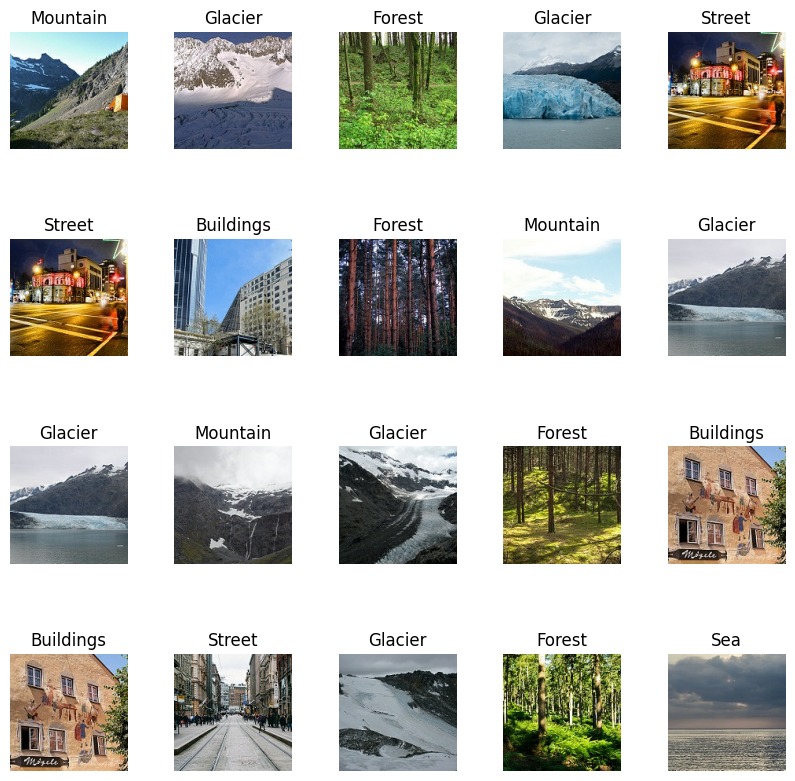

In [20]:
fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(10, 10)) # creating subplot array
for i in range(4):
    for j in range(5):
        index = i * 4 + j
       # if class_name in ["Mountain","Glacier","Sea","Street","Buildings", "Forest"]:
        ax[i, j].imshow(batch[0][index].astype(int)) # print images
        ax[i, j].set_title(cls["class_name"][batch[1][index]]) # print associated titles
        ax[i,j].axis('off') # axis
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()

VGG 16

In [21]:
vgg = VGG16(weights = 'imagenet', include_top = False, input_shape = (150,150,3))

58889256/58889256 [==============================] - 0s 0us/step


In [22]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [26]:
model_vgg = Models.Sequential()
model_vgg.add(vgg)
model_vgg.add(Layers.Flatten())
model_vgg.add(Layers.Dense(256, activation='relu'))
model_vgg.add(Layers.Dropout(0.3))
model_vgg.add(Layers.Dense(6, activation='softmax'))

model_vgg.compile(loss='sparse_categorical_crossentropy', optimizer = Optimizer.Nadam(learning_rate = 2e-5), metrics=['accuracy'])

In [27]:
early_stopping=EarlyStopping(monitor='val_loss',patience=6,restore_best_weights=True)

In [28]:
vgg_train = model_vgg.fit(df_train, validation_data = df_test, validation_split=0.3, epochs =10, callbacks=early_stopping)

Epoch 1/10
281/281 [==============================] - 150s 429ms/step - loss: 1.2517 - accuracy: 0.6719 - val_loss: 0.4263 - val_accuracy: 0.8517
Epoch 2/10
281/281 [==============================] - 109s 388ms/step - loss: 0.3760 - accuracy: 0.8722 - val_loss: 0.3232 - val_accuracy: 0.8880
Epoch 3/10
281/281 [==============================] - 108s 385ms/step - loss: 0.2543 - accuracy: 0.9132 - val_loss: 0.3147 - val_accuracy: 0.8967
Epoch 4/10
281/281 [==============================] - 108s 384ms/step - loss: 0.1923 - accuracy: 0.9344 - val_loss: 0.2835 - val_accuracy: 0.9067
Epoch 5/10
281/281 [==============================] - 109s 387ms/step - loss: 0.1417 - accuracy: 0.9500 - val_loss: 0.2981 - val_accuracy: 0.9060
Epoch 6/10
281/281 [==============================] - 109s 387ms/step - loss: 0.1076 - accuracy: 0.9608 - val_loss: 0.2965 - val_accuracy: 0.9053
Epoch 7/10
281/281 [==============================] - 111s 395ms/step - loss: 0.0762 - accuracy: 0.9740 - val_loss: 0.4321 -

In [29]:
model_vgg.save("vgg_16.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [30]:
model_vgg.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dense_4 (Dense)             (None, 256)               2097408   
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 6)                 1542      
                                                                 
Total params: 16813638 (64.14 MB)
Trainable params: 16813638 (64.14 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
